In [61]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
dwell_ensemble_svm_cv_multiseed.py  (with AUC-ROC  *and* log-odds / odds-ratios)

• Sweeps K_STATES_LIST = [5,6,7,8,9,10]
• Runs the best-state pipeline for each k and RANDOM_SEED
• Inside every CV fold, aggregates the k-specific predictions by majority vote
• Outputs:
    ├─ svm_per_seed_k_summary.csv
    ├─ svm_per_seed_ensemble_summary.csv
    ├─ svm_overall_across_seeds.csv
    ├─ svm_mean_confusion_matrix.csv
    ├─ logit_coeffs_per_fold.csv          ← UPDATED (includes intercept)
    ├─ logit_coeffs_per_seed_k.csv        ← UPDATED (includes intercept_mean/std)
    └─ logit_coeffs_overall.csv           ← UPDATED (includes intercept_mean/std)
"""

import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from sklearn.utils import compute_class_weight
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# ─── PARAMETERS ────────────────────────────────────────────────────────────
BASE_DIR      = Path("/data/s.dharia-ra/PEARL/PEARL/derivatives_selected")
NPZ_DIR       = BASE_DIR / "subject_windows"
WIN_STEP      = 5
TR            = 0.8
K_STATES_LIST = list(range(5, 11))
N_SPLITS      = 10
SEEDS         = [0, 1, 2, 3, 4]

# ─── LOAD DATA ONCE ────────────────────────────────────────────────────────
subj_ids, labels, windows = [], [], []
for npz in sorted(NPZ_DIR.glob("*_windows.npz")):
    data = np.load(npz)
    lab  = data["label"]
    if lab not in ("A+P-", "A+P+"):
        continue
    subj_ids.append(npz.stem.split("_")[0])
    labels.append(0 if lab == "A+P-" else 1)
    windows.append(np.vstack([data["PA"], data["AP"]]))
labels = np.array(labels)
print(f"Loaded {len(subj_ids)} subjects; label counts = {np.bincount(labels)}")

# ─── HELPERS ───────────────────────────────────────────────────────────────
def dwell_times(preds, k):
    """Convert state-sequence → dwell-time vector (seconds)."""
    return np.bincount(preds, minlength=k) * WIN_STEP * TR

def majority_vote(row):
    return Counter(row).most_common(1)[0][0]

# ─── MAIN LOOP ─────────────────────────────────────────────────────────────
rows_k, rows_ens, cms_ens = [], [], []

# NEW ─ rows for coefficients (and intercept)
rows_coef_fold = []

for seed in SEEDS:
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

    # accumulate across folds for ensemble
    y_true_all_ens, y_pred_all_ens, y_score_all_ens = [], [], []

    # per-seed, per-k metrics
    metrics_k = {
        k: {m: [] for m in ("accuracy","precision","recall","f1_macro","aucroc")}
        for k in K_STATES_LIST
    }

    for fold, (tr_idx, te_idx) in enumerate(skf.split(subj_ids, labels)):
        y_pred_mat = np.empty((len(te_idx), len(K_STATES_LIST)), dtype=int)
        y_prob_mat = np.zeros((len(te_idx), len(K_STATES_LIST)), dtype=float)

        for j, k in enumerate(K_STATES_LIST):
            X_tr_win = np.vstack([windows[i] for i in tr_idx])
            km = KMeans(n_clusters=k, random_state=seed, n_init="auto")
            km.fit(X_tr_win)

            dwell_tr = np.vstack([dwell_times(km.predict(windows[i]), k) for i in tr_idx])
            dwell_te = np.vstack([dwell_times(km.predict(windows[i]), k) for i in te_idx])
            y_tr, y_te = labels[tr_idx], labels[te_idx]

            # pick best state via t-test + FDR
            pvals = [
                ttest_ind(dwell_tr[y_tr==0, s], dwell_tr[y_tr==1, s], equal_var=False).pvalue
                for s in range(k)
            ]
            _, p_fdr, _, _ = multipletests(np.array(pvals), method="fdr_bh")
            best_state = int(np.argmin(p_fdr))

            X_feat_tr = dwell_tr[:, best_state].reshape(-1, 1)
            X_feat_te = dwell_te[:, best_state].reshape(-1, 1)

            cw = compute_class_weight("balanced", classes=np.unique(y_tr), y=y_tr)
            class_weights = {0: cw[0], 1: cw[1]}

            clf = make_pipeline(
                MinMaxScaler(),
                LogisticRegression(penalty=None, class_weight=class_weights,
                                   C=1, tol=1e-3, random_state=seed)
            )
            clf.fit(X_feat_tr, y_tr)

            # ── NEW: extract β, intercept, and odds-ratio ───────────────
            logreg   = clf.named_steps["logisticregression"]
            beta     = float(logreg.coef_[0, 0])
            intercept= float(logreg.intercept_[0])
            odds     = np.exp(beta)

            rows_coef_fold.append({
                "seed": seed, "fold": fold, "k": k,
                "coef": beta,
                "intercept": intercept,
                "odds_ratio": odds
            })

            # predictions & AUC
            y_pred = clf.predict(X_feat_te)
            y_prob = clf.predict_proba(X_feat_te)[:, 1]

            # store per-k metrics
            metrics_k[k]["accuracy"].append(accuracy_score(y_te, y_pred))
            metrics_k[k]["precision"].append(precision_score(y_te, y_pred, average="macro"))
            metrics_k[k]["recall"].append(recall_score(y_te, y_pred, average="macro"))
            metrics_k[k]["f1_macro"].append(f1_score(y_te, y_pred, average="macro"))
            metrics_k[k]["aucroc"].append(roc_auc_score(y_te, y_prob))

            y_pred_mat[:, j] = y_pred
            y_prob_mat[:, j] = y_prob

        # ensemble
        y_pred_ens  = np.apply_along_axis(majority_vote, 1, y_pred_mat)
        y_score_ens = y_prob_mat.mean(axis=1)
        y_true_all_ens.extend(labels[te_idx])
        y_pred_all_ens.extend(y_pred_ens)
        y_score_all_ens.extend(y_score_ens)

    # summarize per-k
    for k in K_STATES_LIST:
        row = {"seed": seed, "k": k}
        for m in ("accuracy","precision","recall","f1_macro","aucroc"):
            vals = metrics_k[k][m]
            row[f"{m}_mean"] = np.mean(vals)
            row[f"{m}_std"]  = np.std(vals)
        rows_k.append(row)

    # ensemble summary
    cm_ens = confusion_matrix(y_true_all_ens, y_pred_all_ens, labels=[0,1])
    cms_ens.append(cm_ens)
    rows_ens.append({
        "seed": seed,
        "accuracy":  accuracy_score(y_true_all_ens, y_pred_all_ens),
        "precision": precision_score(y_true_all_ens, y_pred_all_ens, average="macro"),
        "recall":    recall_score(   y_true_all_ens, y_pred_all_ens, average="macro"),
        "f1_macro":  f1_score(      y_true_all_ens, y_pred_all_ens, average="macro"),
        "aucroc":    roc_auc_score( y_true_all_ens, y_score_all_ens)
    })

# ─── BUILD & SAVE DATAFRAMES ─────────────────────────────────────────────────
df_k    = pd.DataFrame(rows_k).set_index(["seed","k"])
df_ens  = pd.DataFrame(rows_ens).set_index("seed")

overall_rows = []
for m in ("accuracy","precision","recall","f1_macro","aucroc"):
    overall_rows.append({
        "metric": m,
        "mean":   df_ens[m].mean(),
        "std":    df_ens[m].std()
    })
mean_cm = np.mean(cms_ens, axis=0)

df_coef_fold   = pd.DataFrame(rows_coef_fold)  # seed × fold × k

# per-seed-k summary (incl intercept)
df_coef_seed_k = (
    df_coef_fold
    .groupby(["seed","k"])
    .agg(
        coef_mean        = ("coef",        "mean"),
        coef_std         = ("coef",        "std"),
        intercept_mean   = ("intercept",   "mean"),
        intercept_std    = ("intercept",   "std"),
        odds_ratio_mean  = ("odds_ratio",  "mean"),
        odds_ratio_std   = ("odds_ratio",  "std")
    )
    .reset_index()
    .set_index(["seed","k"])
)

# overall summary
df_coef_overall = pd.DataFrame({
    "coef_mean"        : [df_coef_fold["coef"].mean()],
    "coef_std"         : [df_coef_fold["coef"].std()],
    "intercept_mean"   : [df_coef_fold["intercept"].mean()],
    "intercept_std"    : [df_coef_fold["intercept"].std()],
    "odds_ratio_mean"  : [df_coef_fold["odds_ratio"].mean()],
    "odds_ratio_std"   : [df_coef_fold["odds_ratio"].std()]
})

# SAVE
df_k.to_csv(BASE_DIR / "svm_per_seed_k_summary.csv")
df_ens.to_csv(BASE_DIR / "svm_per_seed_ensemble_summary.csv")
pd.DataFrame(overall_rows).to_csv(BASE_DIR / "svm_overall_across_seeds.csv", index=False)
pd.DataFrame(mean_cm,
             index=["true_0","true_1"],
             columns=["pred_0","pred_1"]
            ).to_csv(BASE_DIR / "svm_mean_confusion_matrix.csv")

df_coef_fold.to_csv(BASE_DIR / "logit_coeffs_per_fold.csv", index=False)
df_coef_seed_k.to_csv(BASE_DIR / "logit_coeffs_per_seed_k.csv")
df_coef_overall.to_csv(BASE_DIR / "logit_coeffs_overall.csv", index=False)

print("\n✓ Saved metrics, confusion matrices, and updated coefficient tables (with intercept).")


Loaded 42 subjects; label counts = [23 19]


/home/s.dharia-ra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s.dharia-ra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s.dharia-ra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s

KeyboardInterrupt: 

In [ ]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# dwell_ensemble_rf_cv_multiseed.py
# =================================
# • Uses the *full* dwell-time vector (k states) as features
# • Classifier: RandomForest
# • Sweeps K_STATES_LIST = [5,6,7,8,9,10]
# • 10-fold CV × 5 random seeds
# • Majority-vote ensemble over k values inside each outer fold

# Outputs
# -------
#     ├─ rf_per_seed_k_summary.csv
#     ├─ rf_per_seed_ensemble_summary.csv
#     ├─ rf_overall_across_seeds.csv
#     ├─ rf_mean_confusion_matrix.csv
#     └─ rf_feat_importances_per_seed_k.csv      ← optional
# """

# import numpy as np
# import pandas as pd
# from pathlib import Path
# from collections import Counter

# from sklearn.cluster import KMeans
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, roc_auc_score, confusion_matrix
# )
# from sklearn.utils import compute_class_weight

# # ─── PARAMETERS ────────────────────────────────────────────────────────────
# BASE_DIR      = Path("/data/s.dharia-ra/PEARL/PEARL/derivatives_selected")
# NPZ_DIR       = BASE_DIR / "subject_windows"
# WIN_STEP      = 5
# TR            = 0.8
# K_STATES_LIST = list(range(5, 11))
# N_SPLITS      = 10
# SEEDS         = [0, 1, 2, 3, 4]

# # ─── LOAD DATA ONCE ────────────────────────────────────────────────────────
# subj_ids, labels, windows = [], [], []
# for npz in sorted(NPZ_DIR.glob("*_windows.npz")):
#     data = np.load(npz)
#     lab  = data["label"]
#     if lab not in ("A+P-", "A+P+"):
#         continue
#     subj_ids.append(npz.stem.split("_")[0])
#     labels.append(0 if lab == "A+P-" else 1)
#     windows.append(np.vstack([data["PA"], data["AP"]]))
# labels = np.array(labels)
# print(f"Loaded {len(subj_ids)} subjects; label counts = {np.bincount(labels)}")

# # ─── HELPERS ───────────────────────────────────────────────────────────────
# def dwell_times(preds, k):
#     """Convert state indices → dwell-time vector (seconds)."""
#     return np.bincount(preds, minlength=k) * WIN_STEP * TR

# def majority_vote(row):
#     return Counter(row).most_common(1)[0][0]

# # ─── MAIN LOOP ─────────────────────────────────────────────────────────────
# rows_k, rows_ens, cms_ens = [], [], []
# rows_feat_imp = []        # optional

# for seed in SEEDS:
#     skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

#     # accumulate across folds for ensemble
#     y_true_all_ens, y_pred_all_ens, y_score_all_ens = [], [], []

#     # per-seed, per-k metrics
#     metrics_k = {
#         k: {m: [] for m in ("accuracy","precision","recall","f1_macro","aucroc")}
#         for k in K_STATES_LIST
#     }

#     for fold, (tr_idx, te_idx) in enumerate(skf.split(subj_ids, labels)):
#         y_pred_mat = np.empty((len(te_idx), len(K_STATES_LIST)), dtype=int)
#         y_prob_mat = np.zeros((len(te_idx), len(K_STATES_LIST)), dtype=float)

#         for j, k in enumerate(K_STATES_LIST):
#             # ---- Clustering over *all* training windows ----
#             X_tr_win = np.vstack([windows[i] for i in tr_idx])
#             km = KMeans(n_clusters=k, random_state=seed, n_init="auto")
#             km.fit(X_tr_win)

#             # ---- Build dwell-time feature matrices (k dims) ----
#             dwell_tr = np.vstack([dwell_times(km.predict(windows[i]), k) for i in tr_idx])
#             dwell_te = np.vstack([dwell_times(km.predict(windows[i]), k) for i in te_idx])
#             y_tr, y_te = labels[tr_idx], labels[te_idx]

#             # ---- Random-Forest classifier ----
#             cw = compute_class_weight("balanced", classes=np.unique(y_tr), y=y_tr)
#             class_weights = {0: cw[0], 1: cw[1]}

#             clf = make_pipeline(
#                 MinMaxScaler(),
#                 RandomForestClassifier(
#                     n_estimators=500,
#                     max_depth=None,
#                     class_weight=class_weights,
#                     n_jobs=-1,
#                     random_state=seed
#                 )
#             )
#             clf.fit(dwell_tr, y_tr)

#             # ---- Save feature importances (optional) ----
#             rf = clf.named_steps["randomforestclassifier"]
#             rows_feat_imp.append({
#                 "seed": seed,
#                 "fold": fold,
#                 "k": k,
#                 "feature_importances": rf.feature_importances_
#             })

#             # ---- Predictions & probabilities ----
#             y_pred = clf.predict(dwell_te)
#             y_prob = clf.predict_proba(dwell_te)[:, 1]

#             # ---- Store metrics ----
#             metrics_k[k]["accuracy"].append(accuracy_score(y_te, y_pred))
#             metrics_k[k]["precision"].append(precision_score(y_te, y_pred, average="macro"))
#             metrics_k[k]["recall"].append(recall_score(y_te, y_pred, average="macro"))
#             metrics_k[k]["f1_macro"].append(f1_score(y_te, y_pred, average="macro"))
#             metrics_k[k]["aucroc"].append(roc_auc_score(y_te, y_prob))

#             y_pred_mat[:, j] = y_pred
#             y_prob_mat[:, j] = y_prob

#         # ---- Ensemble across k by majority vote ----
#         y_pred_ens  = np.apply_along_axis(majority_vote, 1, y_pred_mat)
#         y_score_ens = y_prob_mat.mean(axis=1)
#         y_true_all_ens.extend(labels[te_idx])
#         y_pred_all_ens.extend(y_pred_ens)
#         y_score_all_ens.extend(y_score_ens)

#     # ---- Summarize per-k ----
#     for k in K_STATES_LIST:
#         row = {"seed": seed, "k": k}
#         for m in ("accuracy","precision","recall","f1_macro","aucroc"):
#             vals = metrics_k[k][m]
#             row[f"{m}_mean"] = np.mean(vals)
#             row[f"{m}_std"]  = np.std(vals)
#         rows_k.append(row)

#     # ---- Ensemble summary (per seed) ----
#     cm_ens = confusion_matrix(y_true_all_ens, y_pred_all_ens, labels=[0,1])
#     cms_ens.append(cm_ens)
#     rows_ens.append({
#         "seed": seed,
#         "accuracy":  accuracy_score(y_true_all_ens, y_pred_all_ens),
#         "precision": precision_score(y_true_all_ens, y_pred_all_ens, average="macro"),
#         "recall":    recall_score(   y_true_all_ens, y_pred_all_ens, average="macro"),
#         "f1_macro":  f1_score(      y_true_all_ens, y_pred_all_ens, average="macro"),
#         "aucroc":    roc_auc_score( y_true_all_ens, y_score_all_ens)
#     })

# # ─── BUILD & SAVE DATAFRAMES ───────────────────────────────────────────────
# df_k    = pd.DataFrame(rows_k).set_index(["seed","k"])
# df_ens  = pd.DataFrame(rows_ens).set_index("seed")

# overall_rows = []
# for m in ("accuracy","precision","recall","f1_macro","aucroc"):
#     overall_rows.append({
#         "metric": m,
#         "mean":   df_ens[m].mean(),
#         "std":    df_ens[m].std()
#     })
# mean_cm = np.mean(cms_ens, axis=0)

# # ---- Optional: aggregate feature importances ----
# fi_records = []
# for rec in rows_feat_imp:
#     seed = rec["seed"]; k = rec["k"]; vec = rec["feature_importances"]
#     fi_records.extend([
#         {"seed": seed, "k": k, "state_idx": i, "importance": vec[i]}
#         for i in range(len(vec))
#     ])
# df_feat_imp = (
#     pd.DataFrame(fi_records)
#       .groupby(["seed","k","state_idx"])["importance"]
#       .agg(["mean","std"])
#       .reset_index()
#       .set_index(["seed","k","state_idx"])
# )

# # ─── SAVE ──────────────────────────────────────────────────────────────────
# df_k.to_csv(BASE_DIR / "rf_per_seed_k_summary.csv")
# df_ens.to_csv(BASE_DIR / "rf_per_seed_ensemble_summary.csv")
# pd.DataFrame(overall_rows).to_csv(BASE_DIR / "rf_overall_across_seeds.csv", index=False)
# pd.DataFrame(mean_cm,
#              index=["true_0","true_1"],
#              columns=["pred_0","pred_1"]
#             ).to_csv(BASE_DIR / "rf_mean_confusion_matrix.csv")
# df_feat_imp.to_csv(BASE_DIR / "rf_feat_importances_per_seed_k.csv")

# print("\n✓ Saved Random-Forest metrics, confusion matrices, and feature-importance tables.")


Loaded 42 subjects; label counts = [23 19]


/home/s.dharia-ra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s.dharia-ra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s.dharia-ra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s


✓ Saved Random-Forest metrics, confusion matrices, and feature-importance tables.


In [ ]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# rf_results_viz.py
# =================
# Visualises Random-Forest dwell-time metrics.

# Creates and saves:
#     1) accuracy_vs_k.png
#     2) ensemble_metric_bars.png
#     3) confusion_matrix_heatmap.png
#     4) feature_importance_heatmap_k{K}.png   (one per k)

# Run from the directory that contains the CSVs emitted by
# dwell_ensemble_rf_cv_multiseed.py.
# """

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from pathlib import Path
# import ast      # for literal list → numpy

# BASE_DIR = Path(".")      # adjust if needed

# # ── 1. Accuracy / F1 vs k ──────────────────────────────────────────────────
# df_k = (
#     pd.read_csv(BASE_DIR / "rf_per_seed_k_summary.csv")
#       .set_index(["seed", "k"])
#       .reset_index()
# )
# # aggregate across seeds
# stats = (
#     df_k.groupby("k")[["accuracy_mean", "f1_macro_mean"]]
#         .agg(["mean", "std"])
# )
# ks  = stats.index.values
# acc = stats["accuracy_mean"]["mean"].values
# acc_err = stats["accuracy_mean"]["std"].values
# f1   = stats["f1_macro_mean"]["mean"].values
# f1_err = stats["f1_macro_mean"]["std"].values

# plt.figure(figsize=(6,4))
# plt.errorbar(ks, acc,  yerr=acc_err,  fmt="-o", label="Accuracy")
# plt.errorbar(ks, f1,   yerr=f1_err,   fmt="-s", label="F1-macro")
# plt.title("CV performance vs k (Random-Forest)")
# plt.xlabel("k (number of states)")
# plt.ylabel("Score")
# plt.xticks(ks)
# plt.ylim(0, 1.0)
# plt.grid(alpha=.3)
# plt.legend()
# plt.tight_layout()
# plt.savefig("accuracy_vs_k.png", dpi=300)
# plt.close()

# # ── 2. Ensemble metrics per seed ───────────────────────────────────────────
# df_ens = pd.read_csv(BASE_DIR / "rf_per_seed_ensemble_summary.csv").set_index("seed")
# metrics = ["accuracy", "precision", "recall", "f1_macro", "aucroc"]
# means = df_ens[metrics].mean().values
# errs  = df_ens[metrics].std().values

# plt.figure(figsize=(6,4))
# x = np.arange(len(metrics))
# plt.bar(x, means, yerr=errs, alpha=0.8)
# plt.xticks(x, metrics, rotation=30, ha="right")
# plt.ylabel("Score")
# plt.title("Seed-level ensemble performance")
# plt.ylim(0, 1.0)
# for xi, m, e in zip(x, means, errs):
#     plt.text(xi, m + 0.03, f"{m:.2f}±{e:.2f}", ha="center")
# plt.tight_layout()
# plt.savefig("ensemble_metric_bars.png", dpi=300)
# plt.close()

# # ── 3. Confusion-matrix heatmap (mean over seeds) ─────────────────────────
# cm = pd.read_csv(BASE_DIR / "rf_mean_confusion_matrix.csv", index_col=0).values
# cm_norm = cm / cm.sum(axis=1, keepdims=True)   # row-normalize

# plt.figure(figsize=(3.5,3))
# plt.imshow(cm_norm, aspect="equal")
# plt.title("Mean confusion matrix (normalized)")
# plt.xlabel("Predicted label")
# plt.ylabel("True label")
# plt.colorbar(fraction=0.046, pad=0.04)
# for i in range(2):
#     for j in range(2):
#         plt.text(j, i, f"{cm[i,j]}\n({cm_norm[i,j]:.2f})",
#                  va="center", ha="center", fontsize=9, fontweight="bold")
# plt.xticks([0,1], ["0  (A+P-)", "1  (A+P+)"])
# plt.yticks([0,1], ["0  (A+P-)", "1  (A+P+)"])
# plt.tight_layout()
# plt.savefig("confusion_matrix_heatmap.png", dpi=300)
# plt.close()

# # ── 4. Feature-importance heatmaps for each k (optional) ───────────────────
# df_imp = (
#     pd.read_csv(BASE_DIR / "rf_feat_importances_per_seed_k.csv")
#       .reset_index()        # seed, k, state_idx, mean, std
# )
# for k, sub in df_imp.groupby("k"):
#     pivot = sub.pivot(index="state_idx", columns="seed", values="mean")
#     plt.figure(figsize=(4, max(3, k/2)))
#     plt.imshow(pivot.values, aspect="auto")
#     plt.title(f"Feature importances, k={k}")
#     plt.xlabel("Seed")
#     plt.ylabel("State index")
#     plt.colorbar(fraction=0.046, pad=0.04, label="Mean importance")
#     plt.yticks(range(k))
#     plt.xticks(range(len(pivot.columns)), pivot.columns)
#     plt.tight_layout()
#     plt.savefig(f"feature_importance_heatmap_k{k}.png", dpi=300)
#     plt.close()

# print("✓ Plots saved next to the CSV files:")
# print("   • accuracy_vs_k.png")
# print("   • ensemble_metric_bars.png")
# print("   • confusion_matrix_heatmap.png")
# print("   • feature_importance_heatmap_k{5-10}.png")


✓ Plots saved next to the CSV files:
   • accuracy_vs_k.png
   • ensemble_metric_bars.png
   • confusion_matrix_heatmap.png
   • feature_importance_heatmap_k{5-10}.png



Per-seed ensemble metrics (10-fold CV):


,seed,accuracy,precision,recall,f1_macro,aucroc
0,0,0.6190,0.6833,0.6430,0.6047,0.6453
1,1,0.5476,0.5417,0.5412,0.5411,0.6705
2,2,0.5952,0.6250,0.6121,0.5894,0.5606
3,3,0.6429,0.6786,0.6602,0.6377,0.6934
4,4,0.5476,0.5556,0.5549,0.5474,0.6247



Grand mean ± SD across seeds (already in csv):


,metric,mean,std
0,accuracy,0.5905,0.0426
1,precision,0.6168,0.0665
2,recall,0.6023,0.0526
3,f1_macro,0.5841,0.0404
4,aucroc,0.6389,0.0508



Per-seed × k grid (peek at top 12 rows):


,seed,k,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_macro_mean,f1_macro_std,aucroc_mean,aucroc_std
0,0,5,0.480,0.1187,0.3733,0.1986,0.4833,0.1225,0.4005,0.1485,0.4583,0.2642
1,0,6,0.555,0.2067,0.4817,0.2916,0.5583,0.2077,0.4905,0.2440,0.5875,0.2625
2,0,7,0.630,0.2182,0.6533,0.2702,0.6333,0.2242,0.6052,0.2361,0.6750,0.2163
3,0,8,0.680,0.2293,0.7167,0.2718,0.7000,0.2273,0.6517,0.2517,0.6083,0.2637
4,0,9,0.575,0.2003,0.5000,0.2814,0.5583,0.2206,0.5036,0.2419,0.5792,0.1692
5,0,10,0.555,0.1955,0.5250,0.2501,0.5667,0.2034,0.5150,0.2181,0.5667,0.1965
6,1,5,0.530,0.1847,0.4625,0.2517,0.5083,0.1805,0.4512,0.1881,0.5458,0.2418
7,1,6,0.595,0.2392,0.5250,0.3114,0.5583,0.2358,0.5176,0.2614,0.6000,0.2882
8,1,7,0.635,0.2086,0.6208,0.2651,0.6417,0.2142,0.6062,0.2286,0.7042,0.2390
9,1,8,0.530,0.2431,0.4883,0.2821,0.5250,0.2556,0.4908,0.2578,0.7042,0.2544


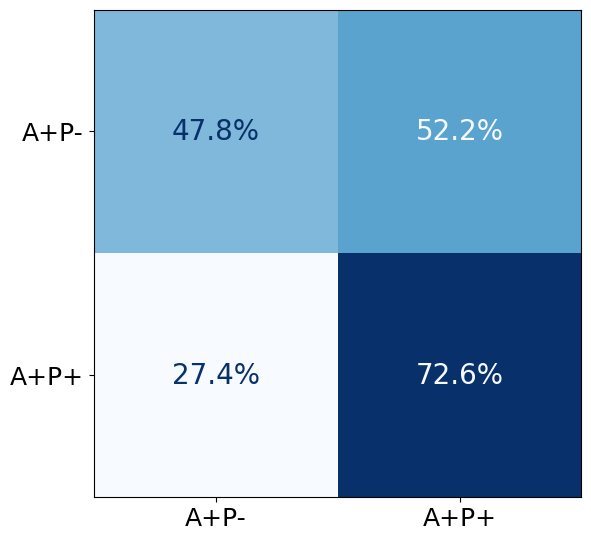

In [17]:
# --- 1. Imports & paths ------------------------------------------------------
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt      # <-- we’ll use plain matplotlib only

BASE_DIR = Path("/data/s.dharia-ra/PEARL/PEARL/derivatives_selected/results_a+p-")

# --- 2. Load the CSV outputs -------------------------------------------------
df_k      = pd.read_csv(BASE_DIR / "svm_per_seed_k_summary.csv")          # seed × k
df_ens    = pd.read_csv(BASE_DIR / "svm_per_seed_ensemble_summary.csv")   # seed
overall   = pd.read_csv(BASE_DIR / "svm_overall_across_seeds.csv")        # grand mean ± SD
mean_cm   = pd.read_csv(BASE_DIR / "svm_mean_confusion_matrix.csv", index_col=0)

# --- 3. Quick textual summaries ---------------------------------------------
print("\nPer-seed ensemble metrics (10-fold CV):")
display(df_ens.round(4))                       # Jupyter nicely formats DataFrames

print("\nGrand mean ± SD across seeds (already in csv):")
display(overall.round(4))

print("\nPer-seed × k grid (peek at top 12 rows):")
display(df_k.head(12).round(4))

# # --- 4. Optional: confusion-matrix heat-map ----------------------------------
# fig, ax = plt.subplots()
# im = ax.imshow(mean_cm.values, vmin=0, cmap="Blues")          # default colormap
# ax.set_xlabel("Predicted"); ax.set_ylabel("True")
# ax.set_xticks([0,1]); ax.set_xticklabels(["0 (Control)","1 (A+P+)"])
# ax.set_yticks([0,1]); ax.set_yticklabels(["0 (Control)","1 (A+P+)"])
# for i in range(mean_cm.shape[0]):
#     for j in range(mean_cm.shape[1]):
#         ax.text(j, i, f"{mean_cm.values[i,j]:.1f}",
#                 ha="center", va="center", fontsize=12, color="white")
# ax.set_title("Mean confusion matrix across seeds (ensemble)")
# plt.tight_layout()
# plt.show()


# --- 4. Confusion-matrix heat-map (scikit-learn version) --------------------
from sklearn.metrics import ConfusionMatrixDisplay      # NEW import

cm_counts = mean_cm.values                              # 2 × 2 ndarray of counts

# --- convert to percentages --------------------------------------------------
# cm_percent = (cm_counts / cm_counts.sum()) * 100        # global %
cm_percent = (cm_counts / cm_counts.sum(axis=1, keepdims=True)) * 100  # row-wise %

# --- plot with sklearn -------------------------------------------------------
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_percent,
    display_labels=["A+P-", "A+P+"],
)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(
    cmap="Blues",
    ax=ax,
    colorbar=False,
    values_format=".1f",        # one decimal place
)

# --- cosmetics ---------------------------------------------------------------
# ax.set_title("Mean confusion matrix across seeds (ensemble) — %", fontsize=16, pad=15)
ax.set_xlabel("", fontsize=30, labelpad=10)
ax.set_ylabel("", fontsize=30, labelpad=10)
ax.tick_params(axis="both", labelsize=18)         # <-- NEW: 14-pt tick labels

# make the cell text bigger
for txt in ax.texts:
    value = float(txt.get_text())          # get current number as float
    txt.set_text(f"{value:.1f}%")          # re-write with percent sign
    txt.set_fontsize(20)                   # keep the larger font

plt.tight_layout()
plt.savefig(BASE_DIR / "mean_confusion_matrix_percentages_A+P-__vs_A+P+.png", dpi=300)
plt.show()


In [24]:
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
from statsmodels.stats.multitest import multipletests

def calculate_coeff(coef_vec, alpha=0.05):
    coef = np.asarray(coef_vec)
    n, df = coef.size, coef.size - 1

    mean = coef.mean()
    sd   = coef.std(ddof=1)
    se   = sd / np.sqrt(n)
    t    = mean / se
    p    = 2 * stats.t.sf(abs(t), df)

    tcrit = stats.t.ppf(1 - alpha/2, df)
    ci_lo = mean - tcrit*se
    ci_hi = mean + tcrit*se

    return mean, sd, t, p, ci_lo, ci_hi

# --- load data ---------------------------------------------------------------
BASE = Path("/data/s.dharia-ra/PEARL/PEARL/derivatives_selected/results_a+p-")
df   = pd.read_csv(BASE / "logit_coeffs_per_fold.csv")

# --- compute per‐k statistics ------------------------------------------------
results = []
for k, sub in df.groupby("k"):
    mean, sd, t, p_raw, ci_lo, ci_hi = calculate_coeff(sub["coef"].values)
    results.append({
        "k":         k,
        "coef_mean": mean,
        "coef_sd":   sd,
        "or_mean":   np.exp(mean),
        "ci_lo":     ci_lo,
        "ci_hi":     ci_hi,
        "p_raw":     p_raw
    })

# --- batch‐correct all the p_raw’s ------------------------------------------
p_raws = np.array([r["p_raw"] for r in results])
_, p_adjeds, _, _ = multipletests(p_raws, alpha=0.05, method="bonferroni")

for r, p_adj in zip(results, p_adjeds):
    r["p_adj"] = p_adj

# --- build the average row --------------------------------------------------
# average each numeric column (including p_adj)
avg_row = {
    "k":         "avg",
    "coef_mean": np.mean([r["coef_mean"] for r in results]),
    "coef_sd":   np.mean([r["coef_sd"]   for r in results]),
    "or_mean":   np.mean([r["or_mean"]   for r in results]),
    "ci_lo":     np.mean([r["ci_lo"]     for r in results]),
    "ci_hi":     np.mean([r["ci_hi"]     for r in results]),
    "p_adj":     np.mean([r["p_adj"]     for r in results])
}

# --- print the table --------------------------------------------------------
header = " k   │  coef_mean  ± SD  │  OR_mean  │  [coef 95% CI]      │  p_adj"
sep    = "─────┼───────────────────┼───────────┼─────────────────────┼──────────"
print(header)
print(sep)
for r in results:
    print(f"{r['k']:>3d}   │ {r['coef_mean']:+8.3f} ± {r['coef_sd']:.3f} │ "
          f"{r['or_mean']:.3f} │ "
          f"[{r['ci_lo']:+.3f}, {r['ci_hi']:+.3f}] │ "
          f"{r['p_adj']:.2e}")
print("─────┴───────────────────┴───────────┴─────────────────────┴──────────")
print(f"{avg_row['k']:>3s}   │ {avg_row['coef_mean']:+8.3f} ± {avg_row['coef_sd']:.3f} │ "
      f"{avg_row['or_mean']:.3f} │ "
      f"[{avg_row['ci_lo']:+.3f}, {avg_row['ci_hi']:+.3f}] │ "
      f"{avg_row['p_adj']:.2e}")


 k   │  coef_mean  ± SD  │  OR_mean  │  [coef 95% CI]      │  p_adj
─────┼───────────────────┼───────────┼─────────────────────┼──────────
  5   │   -1.129 ± 1.881 │ 0.323 │ [-1.664, -0.595] │ 5.83e-04
  6   │   -4.277 ± 2.110 │ 0.014 │ [-4.877, -3.678] │ 2.23e-18
  7   │   -4.757 ± 2.049 │ 0.009 │ [-5.339, -4.175] │ 9.03e-21
  8   │   -4.944 ± 2.072 │ 0.007 │ [-5.533, -4.355] │ 2.86e-21
  9   │   -4.530 ± 2.558 │ 0.011 │ [-5.257, -3.803] │ 4.19e-16
 10   │   -4.007 ± 3.012 │ 0.018 │ [-4.863, -3.151] │ 8.83e-12
─────┴───────────────────┴───────────┴─────────────────────┴──────────
avg   │   -3.941 ± 2.281 │ 0.064 │ [-4.589, -3.293] │ 9.72e-05


In [58]:
# ---------------------------------------------------------------
# 0.  decide how you want to call something an “outlier”
#     here are two common, easy-to-explain rules
# ---------------------------------------------------------------
Z_THRESHOLD  = 3        # |z| > 3  (classical)
OR_THRESHOLD = 10       # OR larger than this is suspicious

# make sure we know which row came from which fold ----------------
# (assume the CSV already has a column called "fold"; if not,    )
# (use reset_index() or enumerate() to create one yourself)      #
if "fold" not in df.columns:
    df = df.reset_index().rename(columns={"index": "fold"})

# ---------------------------------------------------------------
# 1.  loop through k and look for outliers
# ---------------------------------------------------------------
outliers = []          # stash (k, fold, beta, OR, z) tuples here

for k, sub in df.groupby("k"):
    betas   = sub["coef"].values
    or_vals = np.exp(betas)

    # z-scores of β within this k block
    zscores = stats.zscore(betas, ddof=1)

    for row, beta, OR, z in zip(sub.itertuples(), betas, or_vals, zscores):
        #   Rule 1 : |z| > 3   OR
        #   Rule 2 : OR > 10   OR
        #   Rule 3 : β > 0     (unexpected sign)      ← optional
        if (abs(z) > Z_THRESHOLD) or (OR > OR_THRESHOLD) or (beta > 0):
            outliers.append((k, row.fold, beta, OR, z))

# ---------------------------------------------------------------
# 2.  display what we found
# ---------------------------------------------------------------
if outliers:
    print("=== potential outlier folds ===")
    print(" k | fold |   beta   |    OR    |   z-score")
    print("---------------------------------------------")
    for k, fold, beta, OR, z in outliers:
        print(f"{k:2d} | {fold:4d} | {beta:+8.3f} | {OR:8.1f} | {z:+6.2f}")
else:
    print("No folds exceeded the chosen outlier thresholds.")


=== potential outlier folds ===
 k | fold |   beta   |    OR    |   z-score
---------------------------------------------
 5 |    5 |   +0.374 |      1.5 |  +1.25
 5 |    6 |   +0.656 |      1.9 |  +1.79
 5 |    7 |   +0.044 |      1.0 |  +0.61
 5 |    9 |   +0.345 |      1.4 |  +1.19
 5 |    0 |   +0.329 |      1.4 |  +1.16
 5 |    5 |   +0.336 |      1.4 |  +1.17
 5 |    6 |   +0.521 |      1.7 |  +1.53
 5 |    7 |   +0.200 |      1.2 |  +0.91
 5 |    1 |   +0.432 |      1.5 |  +1.36
 5 |    2 |   +0.234 |      1.3 |  +0.98
 5 |    4 |   +0.421 |      1.5 |  +1.34
 5 |    6 |   +0.751 |      2.1 |  +1.98
 5 |    9 |   +0.163 |      1.2 |  +0.84
 5 |    0 |   +0.190 |      1.2 |  +0.89
 5 |    1 |   +0.162 |      1.2 |  +0.84
 5 |    4 |   +0.772 |      2.2 |  +2.01
 5 |    8 |   +0.244 |      1.3 |  +1.00
 6 |    9 |   +0.380 |      1.5 |  +2.90
 6 |    2 |   +0.306 |      1.4 |  +2.72
 6 |    4 |   +0.421 |      1.5 |  +2.99
 7 |    8 |   +0.504 |      1.7 |  +3.60
 7 |    8 |   +1.

In [36]:
e = 2.718281

e**-4.00  # same as above, but more explicit


0.018315661217203738

In [26]:
1/0.064

15.625

In [37]:
import numpy as np
np.exp(-5)    # 0.006737947...
np.exp([-2, 0, 3])   # array([0.13533528, 1.        , 20.08553692])


array([ 0.13533528,  1.        , 20.08553692])